# Prelude

Connect the notebook local directory to Google drive for easy access to the data

In [1]:
from IPython.display import clear_output

In [2]:
# Clone Allan Online repo to notebook directory
!git clone https://github.com/nurriol2/allan-online.git
!pip install lmfit
clear_output()

In [3]:
import os
import sys
allan_online_dir = "./allan-online"
sys.path.append(os.path.abspath(allan_online_dir))
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
#from scipy import optimize
import scipy as scipy
from lmfit.models import ConstantModel, LorentzianModel

In [4]:
if os.path.isdir("/content/heterodyne/") and os.path.isdir("/content/split_detection/"):
    pass
else:
    !unzip /content/drive/MyDrive/allan_data/heterodyne.zip
    !unzip /content/drive/MyDrive/allan_data/split_detection.zip
clear_output()

# Processing Methods

These methods make it easy to load in .CSV files containing the spectra data.

In [5]:
def columns_to_array(df):
    """
    Create individual numpy arrays from columns of a data frame

    Args:
    df (pd.DataFrame):  The data frame to convert

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """
    result = []
    for _, col_data in df.iteritems():
        result.append(col_data.values)
    return result

def load_csv_file(fullpath, units):
    """
    Load a single csv file into memory as a pandas.DataFrame
    
    Args:
    fullpath (str):  The full path to the CSV file

    units (str):  Units to use for the spectral density.
                  Typically m^2/Hz or V^2/Hz.
    """
    return pd.read_csv(fullpath, names=["Frequency (Hz)", f"Spectral Density ({units})"])

def process_csv_file(fullpath, units):

    """
    Load a single CSV file into memeory as numpy arrays

    Args:
    fullpath (str):  The full path to the CSV file

    units (str):  Units to use for the spectral density.
                  Typically m^2/Hz or V^2/Hz.

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """

    df = load_csv_file(fullpath, units)

    return columns_to_array(df)

def match_filenames_in_dir(pattern, dirpath):

    """
    Search a directory tree for all filenames which match a specified pattern

    Args:
    pattern (str):  Expression for the filename template.

    directory(str):  Path to directory where data files are located.

    Returns:
    (list(str)):  List of all the filenames which match a specified pattern.
    """

    # List of all found files that match pattern
    result = []
    # Walk the tree
    for root, dirs, files in os.walk(dirpath):
        # Only care about files within the directory
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [6]:
def sort_key(fullpath):
    """
    Find the file number from the path to a file.
    Example:  Extract the number 109 from /.../cha_st80_109.CSV

    Args:
    fullpath (str):  The full path to the CSV file

    Returns:
    (int):  The found file number
    """

    filename = fullpath.split('/')[-1]
    filenumber = filename.split('_')[-1].strip(".CSV")
    return int(filenumber)

# Constant Patterns for Data sets

In [7]:
data_sets = {"cha":{"directory":"/content/split_detection/",
                    "pattern":"cha_st80_*.CSV",
                    "units":"m^2/Hz"},
             "chb":{"directory":"/content/split_detection/",
                    "pattern":"chb_st80_*.CSV",
                    "units":"m^2/Hz"},
             "het":{"directory":"/content/heterodyne/",
                    "pattern":"het_st80_*.CSV",
                    "units":"V^2/Hz"}}

# Visualize the Data

Superimpose the data onto a single plot (one for each data set) to get a general sense for shape and magnitude.

In [8]:
def super_plot(pattern, directory, title, units="m^2/Hz"):

    """
    Superimpose all spectra found within a directory onto a single plot

    Args:
    pattern (str):  Expression for the filename template.

    directory(str):  Path to directory where data files are located.
    """
    
    # Get a list of files
    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)
    
    # Set up a single figure 
    fig = plt.figure()
    ax = fig.add_subplot(111, title=title, xlabel="Frequency (Hz)", ylabel=f"Spectral Density ({units})")

    # Add lines to the figure
    for path in filepaths:
        df = load_csv_file(path, f"{units}")
        freq = df["Frequency (Hz)"]
        spectra = df[f"Spectral Density ({units})"]
        ax.plot(freq, spectra)
    
    plt.show()
    return 

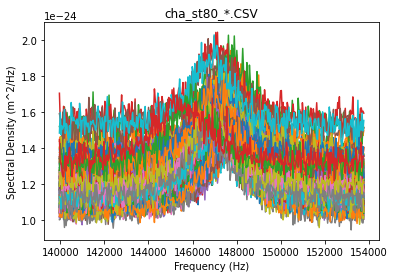

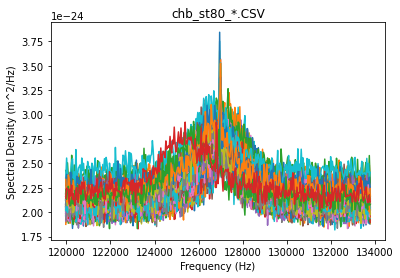

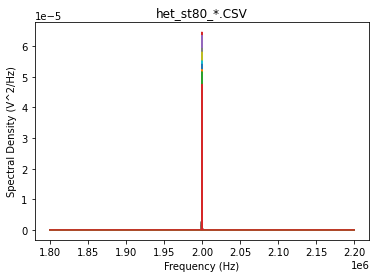

In [9]:
for data in data_sets.values():
    super_plot(data["pattern"], data["directory"], data["pattern"], data["units"])
    print("\n")

For the Heterodyne data, it would be helpful to focus the view on the central peak.

In [10]:
def center_zoom(arr, window):
    """
    Trim an array to select a centered view of size `window` 

    Args:
    arr (np.ndarray):  An array of values.

    window (int):  The size of the window to view.

    Returns:
    (np.ndarray):  The same as `arr` with window//2 elements to the left and 
                   right of the midpoint.
    """

    center = len(arr)//2
    left = center-window//2
    right = center+window//2
    selection = arr[left:right]
    return selection 

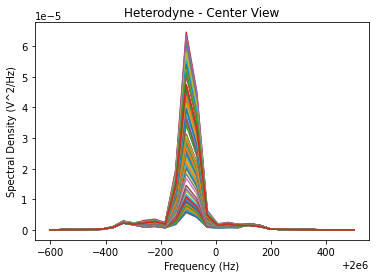

In [11]:
window_size = 30
units = "V^2/Hz" # Since looking at heterodyne data

# Get a list of files
filepaths = match_filenames_in_dir(data_sets["het"]["pattern"], data_sets["het"]["directory"])
filepaths.sort(key=sort_key)

# Set up a single figure 
fig = plt.figure()
ax = fig.add_subplot(111, title="Heterodyne - Center View", xlabel="Frequency (Hz)", ylabel=f"Spectral Density ({units})")

# Add lines to the figure
for path in filepaths:
    df = load_csv_file(path, f"{units}")
    freq = center_zoom(df["Frequency (Hz)"], window_size)
    spectrum = center_zoom(df[f"Spectral Density ({units})"], window_size)
    ax.plot(freq, spectrum)

plt.show()


# Lorentzian Fit

As seen in the previous section, sideband data (`cha_...` and `chb_...`) contain a single peak. A spectrum can be fit with the Lorentzian. 

In the following section, a fitting procedure is defined.

In [12]:
def lorentz_1d(x, amp, sigma, center):
    """
    Implement a single peak Lorentzian according to the formula at
    https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Lorentz1D.html

    Args:
    x (np.ndarray):  Values the where the Lorentzian should be computed.

    amp (float):  The amplitude of the peak.

    sigma (float):  The FWHM value of the peak. 

    center (float):  The value in the domain where the peak occurs.

    Returns:
    (np.ndarray(float)):  Values of the Lorentzian 

    """
    return (amp*sigma**2)/(sigma**2+(x-center)**2)

---

In [13]:
def plot_best_fit(freq, spectrum, best_fit_arr, title, units="m^2/Hz"):
    """
    Plot the best fit curve on top of the measured spectral density

    Args:
    freq (np.ndarray(float)):  A row array of frequency values.

    spectrum (np.ndarray(float)):  A row array of spectral density values. 
                                   Example:  Values found in chb_st80_10 as a row array

    best_fit_arr (np.ndarray(float)):  Values of the best fit curve as a row array

    title (str):  The title of the plot. Typically the file pattern or filename.

    units (str, optional):  Units to use for the spectral density.
                            Typically m^2/Hz or V^2/Hz.  
    """

    # Plot the raw data
    plt.plot(freq, spectrum, label="Spectral Density")
    # Plot the best fit curve
    plt.plot(freq, best_fit_arr, label="Best Fit")

    plt.legend()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(f"Spectra ({units})")
    plt.title(title)
    
    plt.show()
    
    return 

In [14]:
def extract_single_peak(freq, spectrum):
    # TODO:  Write a class to access attributes instead of indexing into a dict

    """
    Applies a Lorentzian fit function to the peak and extract 
    its area, mechanical frequency, and linewidth

    Args:
    freq (np.ndarray(float)):  A row array of frequency values.

    spectrum (np.ndarray(float)):  A row array of spectral density values. 
                                   Example:  Values found in chb_st80_10 as a row array

    Returns:
    (dict):
        "raw area" (float):  The area under the data curve, before a fit is applied.
        
        "fit area" (float):  The area under the best fit curve. 
        
        "mechanical frequency" (float):  The amplitude of the peak.
        
        "linewidth" (float):  The full width at half maximum (FWHM).

        "best fit object" (lmfit.model.ModelResult):  The best fit model object.
                                                      Useful for interacting with lmfit

    """
    
    # Build the model
    peak = LorentzianModel()
    background = ConstantModel()

    # Define model parameters
    pars = background.make_params(c=spectrum.min())
    pars += peak.guess(spectrum, x=freq)

    model = peak + background

    # Fit the model 
    out = model.fit(spectrum, pars, x=freq)
    
    # Extract area, mechanical frequency, and linewidth
    raw_area = np.trapz(spectrum)
    fit_area = np.trapz(out.best_fit)
    mech_freq = out.best_values["amplitude"]
    linewidth = 2*out.best_values["sigma"]


    return {"raw area":raw_area,
            "fit area":fit_area,
            "mechanical frequency":mech_freq,
            "linewidth":linewidth,
            "best fit object":out}

## Example:  Determining the Best Fit Curve and Extracting Values

The following section demonstrates finding a best fit curve for a single peak spectrum. In this case, `cha_st80_1.CSV`

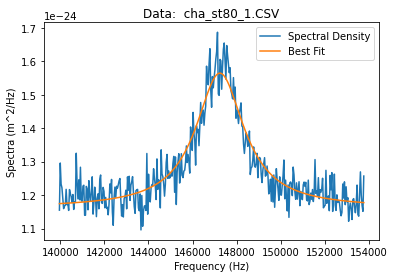

In [15]:
# Apply fitting to just 1 spectra 
cha1 = load_csv_file("/content/split_detection/cha_st80_1.CSV", "m^2/Hz")
freq = cha1["Frequency (Hz)"]
spectrum = cha1["Spectral Density (m^2/Hz)"]

cha1_best_fit = extract_single_peak(freq, spectrum)["best fit object"]
plot_best_fit(freq, spectrum, cha1_best_fit.best_fit, "Data:  cha_st80_1.CSV")

In [16]:
cha1_best_fit.best_values

{'amplitude': 1.691638732823799e-21,
 'c': 1.1613205730717953e-24,
 'center': 147241.9752162465,
 'sigma': 1335.1441764831543}

Examine values from the best fit model

In [17]:
extract_single_peak(freq, spectrum)

{'best fit object': <lmfit.model.ModelResult at 0x7f5546d8e690>,
 'fit area': 4.593357235347419e-22,
 'linewidth': 2670.2883529663086,
 'mechanical frequency': 1.691638732823799e-21,
 'raw area': 4.593058036684815e-22}

---

## Heterodyne Data - Multiple Peaks

For heterodyne data, we care about the two minor peaks that appear on either side of the main peak.

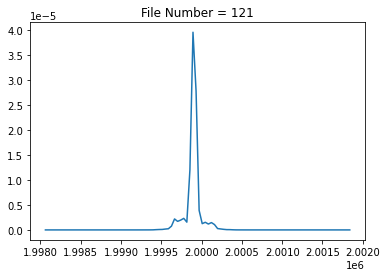

In [18]:
# Plot a heterodyne spectra to visualize the left and right peaks

window_size = 100
#random_filenumber = np.random.randint(1, 125)
random_filenumber = 121

het1 = load_csv_file(f"/content/heterodyne/het_st80_{random_filenumber}.CSV", "V^2/Hz")

het1_freq = center_zoom(het1["Frequency (Hz)"], window_size)
het1_spectra = center_zoom(het1["Spectral Density (V^2/Hz)"], window_size)

plt.plot(het1_freq, het1_spectra)
plt.title(f"File Number = {random_filenumber}")
plt.show()

~~Might have to tweak the `rel_height` parameter to get the desired minor peaks.~~

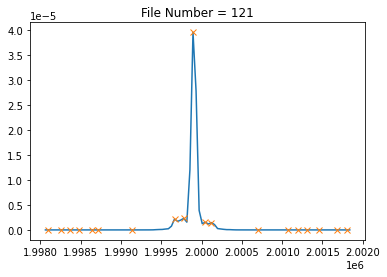

In [19]:
#peaks, _ = find_peaks(het1_spectra, height=het1_spectra.max())
peaks, _ = find_peaks(het1_spectra)
plt.plot(het1_freq, het1_spectra)
plt.plot(het1_freq.to_numpy()[peaks], het1_spectra.to_numpy()[peaks], "x")
plt.title(f"File Number = {random_filenumber}")
plt.show()

When fitting a model, we need to provide a guess for the center of the peak. If we sort the peaks by the associated height, then the major peak should be the largest value and the 2 minor peaks should be (close to) the next 2 largest values.

In [20]:
def peak_selection(heights_and_indices):
    """
    Select one peak on either side of a central peak.
    """

    heights_and_indices.sort(key=lambda pair : pair[0], reverse=True)

    center_height, center_idx = heights_and_indices[0]
    height_a, idx_a = heights_and_indices[1]

    b = None
    # The next tallest peak is left of center
    if idx_a < center_idx:
        b = next(pair for pair in heights_and_indices[2:] if pair[1] > center_idx)
    # The next tallest peak is right of center
    else:
        b = next(pair for pair in heights_and_indices[2:] if pair[1] < center_idx)
    
    return [(center_height, center_idx), (height_a, idx_a), (b)]

In [21]:
heights_and_indices = list(zip(het1_spectra.to_numpy()[peaks], peaks))
heights_and_indices.sort(key=lambda pair : pair[0], reverse=True)
heights_and_indices

[(3.963443198988304e-05, 48),
 (2.314810774274825e-06, 45),
 (2.200064469946326e-06, 42),
 (1.5295557672797429e-06, 52),
 (1.4690306208267608e-06, 54),
 (7.703160405949413e-10, 11),
 (7.470824813995792e-10, 28),
 (7.214319996037273e-10, 69),
 (5.293785985122565e-10, 85),
 (6.027986382772649e-11, 8),
 (6.010629114981116e-11, 82),
 (5.444329786651385e-11, 15),
 (5.3492898752036456e-11, 79),
 (5.265682763385146e-11, 5),
 (4.98783829162455e-11, 89),
 (4.570041503097164e-11, 98),
 (4.2613497524579945e-11, 17),
 (3.329928824321124e-11, 1),
 (2.8814559079716126e-11, 95)]

Text(0.5, 1.0, 'File Number = 121')

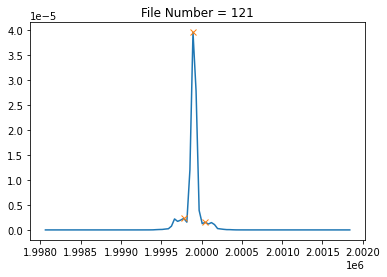

In [22]:
desired_heights = [pair[0] for pair in peak_selection(heights_and_indices)]
desired_indices = [pair[1] for pair in peak_selection(heights_and_indices)]


plt.plot(het1_freq, het1_spectra)
plt.plot(het1_freq.to_numpy()[desired_indices], desired_heights, "x")
plt.title(f"File Number = {random_filenumber}")

Now we can make the composite model

In [23]:
hfreq = het1_freq.to_numpy()
hspec = het1_spectra.to_numpy()

In [24]:
desired_indices

[48, 45, 52]

In [25]:
desired_heights

[3.963443198988304e-05, 2.314810774274825e-06, 1.5295557672797429e-06]

## First Try Multiple Peaks

In [26]:
cent_model = LorentzianModel(prefix="center_")
pars = cent_model.guess(hspec, x=hfreq)

minor1 = LorentzianModel(prefix="minor1_")
pars.update(minor1.make_params())
pars["minor1_center"].set(value=hfreq[desired_indices[1]])
pars["minor1_amplitude"].set(value=desired_heights[1])

minor2 = LorentzianModel(prefix="minor2_")
pars.update(minor2.make_params())
pars["minor2_center"].set(value=hfreq[desired_indices[2]])
pars["minor2_amplitude"].set(value=desired_heights[2])

background = ConstantModel()
pars.update(background.make_params(c=hspec.min()))

combined_model = cent_model + minor1 + minor2 + background
out = combined_model.fit(hspec, pars, x=hfreq)

components = out.eval_components(x=hfreq)

print(out.fit_report())

[[Model]]
    (((Model(lorentzian, prefix='center_') + Model(lorentzian, prefix='minor1_')) + Model(lorentzian, prefix='minor2_')) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 508
    # data points      = 100
    # variables        = 10
    chi-square         = 3.0393e-11
    reduced chi-square = 3.3770e-13
    Akaike info crit   = -2862.19900
    Bayesian info crit = -2836.14730
[[Variables]]
    center_amplitude:  0.00408511 +/- 3.7762e-04 (9.24%) (init = 0.09355085)
    center_center:     1999907.58 +/- 1.27254991 (0.00%) (init = 1999893)
    center_sigma:      24.1627445 +/- 2.92309790 (12.10%) (init = 629.4251)
    center_fwhm:       48.3254891 +/- 5.84619580 (12.10%) == '2.0000000*center_sigma'
    center_height:     5.3816e-05 +/- 1.0242e-05 (19.03%) == '0.3183099*center_amplitude/max(1e-15, center_sigma)'
    minor1_amplitude:  0.21081198 +/- 39473.7571 (18724626.80%) (init = 2.314811e-06)
    minor1_center:     1923799.03 +/- 

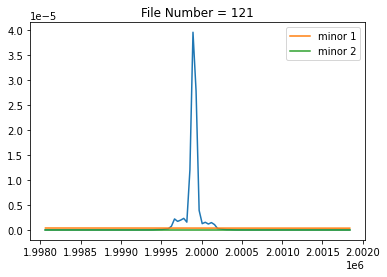

In [27]:
plt.plot(hfreq, hspec)
#plt.plot(hfreq, out.best_fit)
plt.plot(hfreq, components["minor1_"], label="minor 1")
plt.plot(hfreq, components["minor2_"], label="minor 2")

plt.title(f"File Number = {random_filenumber}")
plt.legend()

Estimate the min/max guessing range as half the distance between a minor peak and the center peak.

In [28]:
estimated_width = (hfreq[desired_indices[0]]-hfreq[desired_indices[1]])/2
alpha = 3

In [29]:
cent_model = LorentzianModel(prefix="center_")
pars = cent_model.guess(hspec, x=hfreq)



minor1 = LorentzianModel(prefix="minor1_")
pars.update(minor1.make_params())

pars["minor1_center"].set(value=hfreq[desired_indices[1]], 
                          min=hfreq[desired_indices[1]]+alpha*estimated_width, 
                          max=hfreq[desired_indices[1]]+2*alpha*estimated_width)

pars["minor1_amplitude"].set(value=desired_heights[1])



minor2 = LorentzianModel(prefix="minor2_")
pars.update(minor2.make_params())

pars["minor2_center"].set(value=hfreq[desired_indices[2]],
                          min=hfreq[desired_indices[2]]+alpha*estimated_width,
                          max=hfreq[desired_indices[2]]+2*alpha*estimated_width)
pars["minor2_amplitude"].set(value=desired_heights[2])

combined_model = cent_model + minor1 + minor2
out = combined_model.fit(hspec, pars, x=hfreq)

components = out.eval_components(x=hfreq)

print(out.fit_report())

[[Model]]
    ((Model(lorentzian, prefix='center_') + Model(lorentzian, prefix='minor1_')) + Model(lorentzian, prefix='minor2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 261
    # data points      = 100
    # variables        = 9
    chi-square         = 3.0399e-11
    reduced chi-square = 3.3406e-13
    Akaike info crit   = -2864.17660
    Bayesian info crit = -2840.73006
##  Warning: uncertainties could not be estimated:
    center_center:     at initial value
    minor1_center:     at initial value
    minor1_center:     at boundary
    minor2_center:     at initial value
    minor2_center:     at boundary
[[Variables]]
    center_amplitude:  0.00408519 (init = 0.09355085)
    center_center:     1999907.58 (init = 1999893)
    center_sigma:      24.1645130 (init = 629.4251)
    center_fwhm:       48.3290261 == '2.0000000*center_sigma'
    center_height:     5.3813e-05 == '0.3183099*center_amplitude/max(1e-15, center_sigma)'
    minor1_amplitude: 

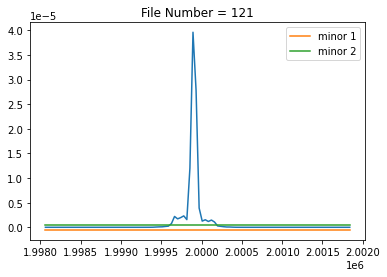

In [30]:
plt.plot(hfreq, hspec)
#plt.plot(hfreq, out.best_fit)
plt.plot(hfreq, components["minor1_"], label="minor 1")
plt.plot(hfreq, components["minor2_"], label="minor 2")
plt.title(f"File Number = {random_filenumber}")
plt.legend()

(With limited testing) Composite models are unable to fit the multiple peaks. Instead, can look into scipy's optimize method.

In [31]:
hfreq[desired_indices]

array([1999893.38846588, 1999778.94753647, 2000045.97637176])

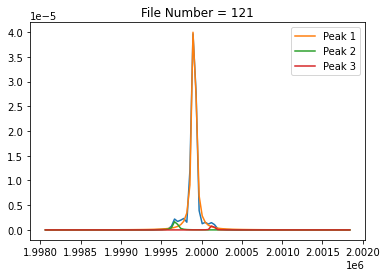

In [32]:
def _1Lorentzian(x, amp, cen, wid):
    """
    Lorentzian with 1 peak

    Args:
    x (np.ndarray(float)):  Values where the Lorentzian is evaluated.

    amp (float):  The amplitude of the peak.

    cen (float):  The value in the domain where the peak is found.

    wid (float):  Full width at half maximum (FWHM).

    Returns:
    (np.ndarray(float)):  Values for the Lorentzian computed over `x`
    """
    return amp*wid**2/((x-cen)**2+wid**2)

def _3Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2, amp3,cen3,wid3):

    """
    Lorentzian with 3 peaks
    """

    return _1Lorentzian(x, amp1, cen1, wid1) + _1Lorentzian(x, amp2, cen2, wid2) + _1Lorentzian(x, amp3, cen3, wid3)


amp1, amp2, amp3 = desired_heights
cen1, cen2, cen3 = hfreq[desired_indices]
wid1, wid2, wid3 = (10, 5, 5) # These are purely random guesses
popt_3lorentz, pcov_3lorentz = scipy.optimize.curve_fit(_3Lorentzian, hfreq, hspec, p0=[amp1, cen1, wid1, \
                                                                                    amp2, cen2, wid2, amp3, cen3, wid3])

perr_3lorentz = np.sqrt(np.diag(pcov_3lorentz))

pars_1 = popt_3lorentz[0:3]
pars_2 = popt_3lorentz[3:6]
pars_3 = popt_3lorentz[6:9]
lorentz_peak_1 = _1Lorentzian(hfreq, *pars_1)
lorentz_peak_2 = _1Lorentzian(hfreq, *pars_2)
lorentz_peak_3 = _1Lorentzian(hfreq, *pars_3)

plt.plot(hfreq, hspec)
plt.plot(hfreq, lorentz_peak_1, label="Peak 1")
plt.plot(hfreq, lorentz_peak_2, label="Peak 2")
plt.plot(hfreq, lorentz_peak_3, label="Peak 3")

plt.title(f"File Number = {random_filenumber}")
plt.legend()

In [33]:
lorentz_peak_1

array([8.82828279e-09, 9.20482960e-09, 9.60598984e-09, 1.00339562e-08,
       1.04911713e-08, 1.09803620e-08, 1.15045809e-08, 1.20672535e-08,
       1.26722346e-08, 1.33238744e-08, 1.40270966e-08, 1.47874924e-08,
       1.56114309e-08, 1.65061939e-08, 1.74801365e-08, 1.85428832e-08,
       1.97055664e-08, 2.09811189e-08, 2.23846349e-08, 2.39338188e-08,
       2.56495454e-08, 2.75565667e-08, 2.96844090e-08, 3.20685222e-08,
       3.47517644e-08, 3.77863406e-08, 4.12363587e-08, 4.51812407e-08,
       4.97203298e-08, 5.49792003e-08, 6.11184260e-08, 6.83459688e-08,
       7.69349986e-08, 8.72500458e-08, 9.97862551e-08, 1.15229805e-07,
       1.34553608e-07, 1.59173935e-07, 1.91216620e-07, 2.33989939e-07,
       2.92869775e-07, 3.77064311e-07, 5.03415706e-07, 7.05430529e-07,
       1.05764151e-06, 1.75374708e-06, 3.42821364e-06, 9.09352692e-06,
       3.99659043e-05, 2.71325577e-05, 6.87414577e-06, 2.85005096e-06,
       1.53127401e-06, 9.50558760e-07, 6.46096496e-07, 4.67228196e-07,
      

# How Does Applying a Fit Affect Area Under Peak?

- Try: Simpson's rule 
    - 100x the percent error
    - Reverted back to only using the trapezoid rule

In [34]:
# Calculate the percent error between the area under
# the raw spectra data and the area under the best fit curve
pct_err = lambda a, e : 100*abs(e-a)/abs(a)

In [35]:
def single_peak_area_differences(dataset):

    """
    Compute the percent difference between the area under the 
    Lorentzian fit and the raw data using the trapezoid integration rule
    """

    directory = dataset["directory"]
    pattern = dataset["pattern"]
    units = dataset["units"]

    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)

    trapz_errors = []
    simpson_errors = []

    for path in filepaths:
        df = load_csv_file(path, units)
        freq = df["Frequency (Hz)"]
        spectrum = df[f"Spectral Density ({units})"]

        best_fit = extract_single_peak(freq, spectrum)
        trapz_errors.append(pct_err(best_fit["raw area"], best_fit["fit area"]))
    
    plt.bar(np.arange(1, 125), trapz_errors, label="Trapezoid Rule")
    plt.legend()
    plt.xlabel("File Number")
    plt.ylabel("Percent Error (%)")
    plt.title(f"Data Set:  {pattern}")
    plt.show()
    return 

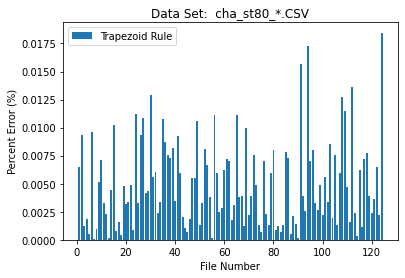

In [36]:
# Channel A
single_peak_area_differences(data_sets["cha"])

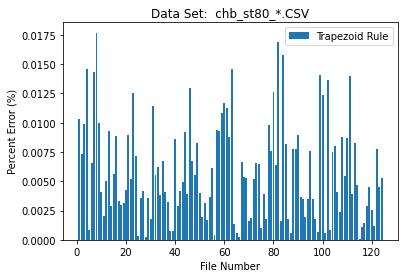

In [37]:
# Channel B
single_peak_area_differences(data_sets["chb"])

---

# Using OADEV on Pre-extracted Data

In [38]:
# The way to load in .dat files
areax = np.loadtxt("/content/split_detection/areax.dat")
areay = np.loadtxt("/content/split_detection/areay.dat")
fx = np.loadtxt("/content/split_detection/fx.dat")
fy = np.loadtxt("/content/split_detection/fy.dat")
neg_sideband = np.loadtxt("/content/heterodyne/fit_neg_sideband.dat")

In [39]:
# Load in `fit_pos_sideband.dat)`
pos_sideband = np.loadtxt("/content/heterodyne/fit_pos_sideband.dat")
print("File:  fit_pos_sideband.dat")
# Shape of the loaded data
print(f"(Rows, Cols) = {pos_sideband.shape}\n")

# First row of data
print(f"First row of values\n{pos_sideband[0,:]}\n")

# First 10 values of the 7th column
print(f"Some values from the 7th column\n{pos_sideband[:, 6][:10]}\n")

File:  fit_pos_sideband.dat
(Rows, Cols) = (124, 7)

First row of values
[1.21485797e-09 2.12674498e+06 1.91427456e+03 9.20779229e-10
 2.14719985e+06 2.09129374e+03 3.15291170e-14]

Some values from the 7th column
[3.15291170e-14 3.26019909e-14 3.02998273e-14 3.35576462e-14
 3.20137599e-14 3.21524999e-14 3.09300499e-14 3.29394824e-14
 3.19799747e-14 2.81970978e-14]



In [40]:
from allan_variance import overlapping_allan_deviation
from coefficient_fitting import fit_random_walk_line, fit_rate_random_walk_line, fit_bias_instability_line

def run_oadev(data, delta_t, title, maxNumM=62):

    taus, oadev = overlapping_allan_deviation(data, Fs=1/delta_t, maxNumM=maxNumM)

    fit_rw = fit_random_walk_line(taus, oadev)
    fit_rrw = fit_rate_random_walk_line(taus, oadev)
    fit_bi = fit_bias_instability_line(taus, oadev)

    plt.figure(figsize=(12,8))
    plt.loglog(taus, oadev, label="OADEV")
    plt.legend()
    plt.title(f"Overlapping Allan Deviation for `{title}`");
    plt.show()

    plt.figure(figsize=(12,8))
    plt.loglog(taus, oadev, label="OADEV")
    plt.loglog(taus, fit_rw[0], label=f"Random Walk = {fit_rw[1]}")
    plt.loglog(taus, fit_rrw[0], label=f"Rate Random Walk = {fit_rrw[1]}")
    plt.loglog(taus, fit_bi[0], label=f"Bias Instability = {fit_bi[1]}")
    plt.legend()
    plt.title(f"Overlapping Allan Deviation for `{title}` with Fit Lines");
    plt.show()

    print("\n\n")
    return 

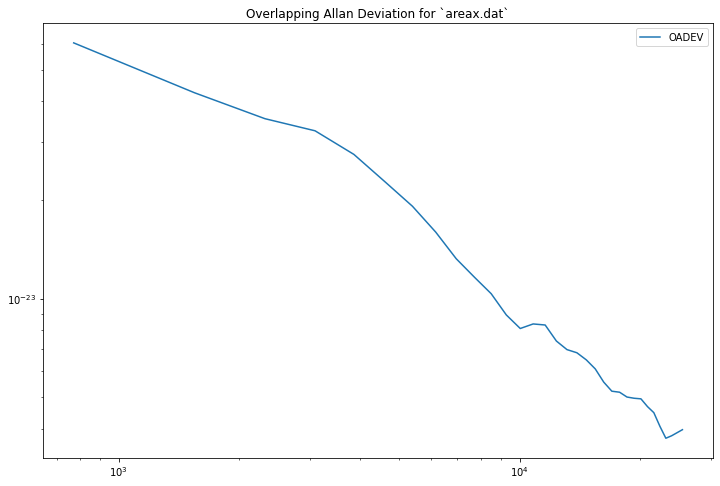

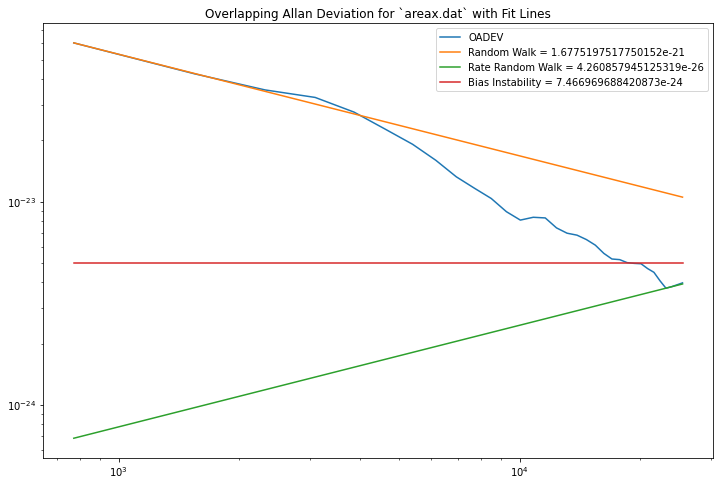

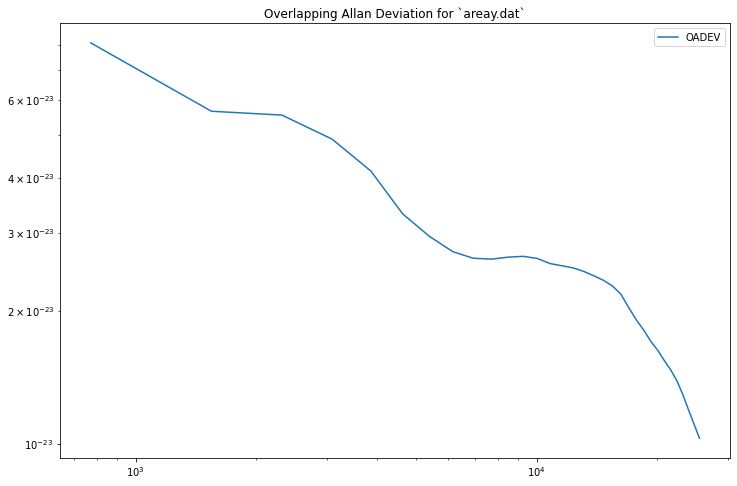

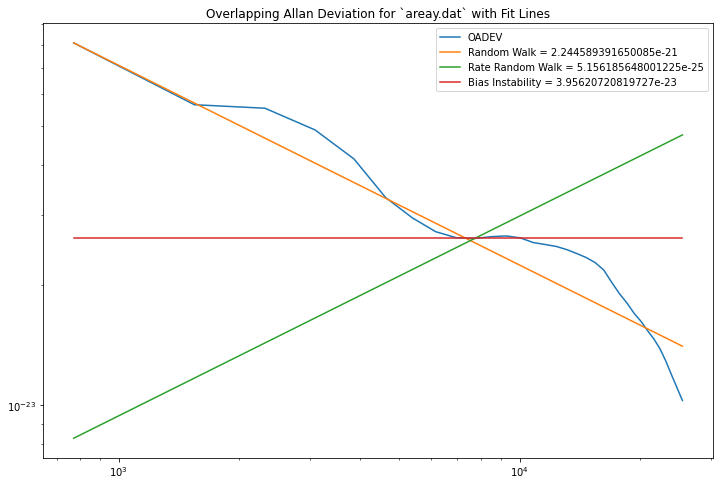

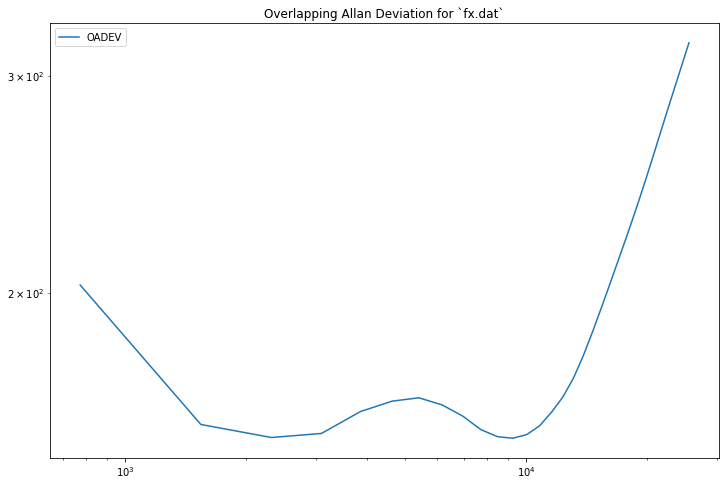

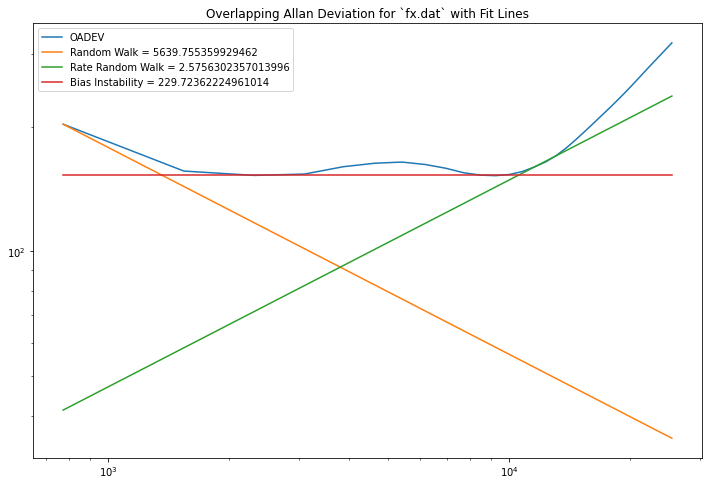

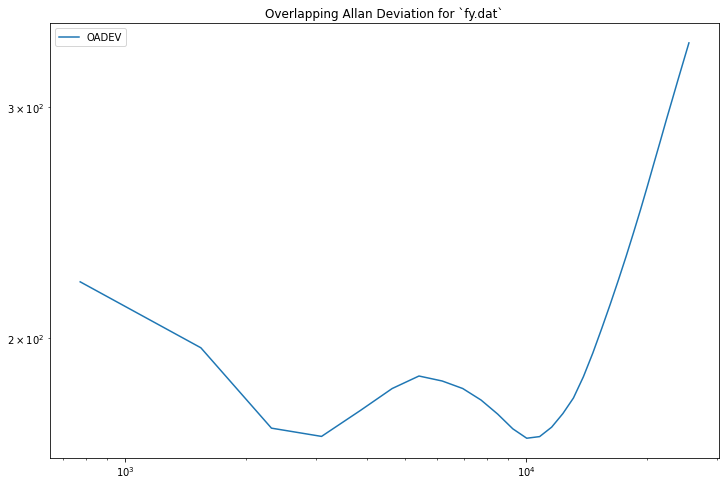

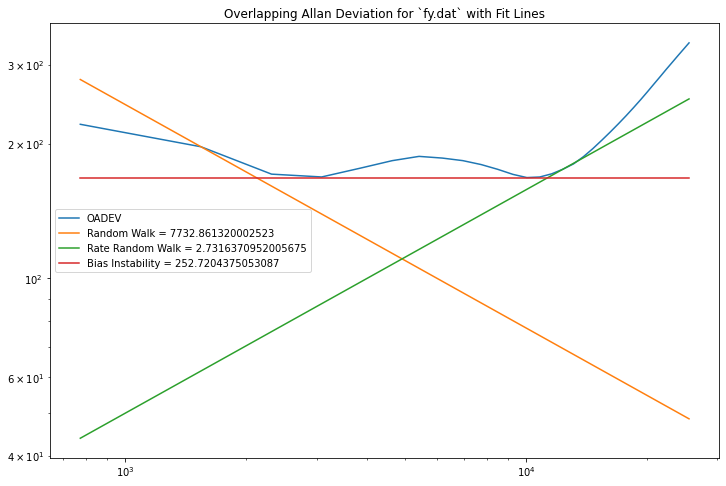

In [41]:
run_oadev(areax, 772.26, "areax.dat", maxNumM=100)
run_oadev(areay, 772.26, "areay.dat", maxNumM=100)
run_oadev(fx, 772.26, "fx.dat", maxNumM=100)
run_oadev(fy, 772.26, "fy.dat", maxNumM=100)


#run_oadev(neg_sideband, 326.613, "fit_neg_sideband.dat", maxNumM=100)
#run_oadev(pos_sideband, 326.613, "fit_pos_sideband.dat", maxNumM=100)

---

# Package everything together

## Helper Functions

In [42]:
# Helper functions

def match_filenames_in_dir(pattern, directory):

    """
    Search a directory tree for all filenames which match a specified pattern

    Args:
    pattern (str):  Expression for the filename template.

    directory(str):  Path to directory where data files are located.

    Returns:
    (list(str), list(str)):  A tuple of lists. 
                             The first list contains full paths to found files.
                             The second list contains only the file names.
    """

    # List of all found files that match pattern
    full_paths = []
    filenames = []
    # Walk the tree
    for root, dirs, files in os.walk(directory):
        # Only care about files within the directory
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                full_paths.append(os.path.join(root, name))
                filenames.append(name)
    return (full_paths, filenames)


def center_zoom(arr, window):
    """
    Trim an array to select a centered view of size `window` 

    Args:
    arr (np.ndarray):  An array of values.

    window (int):  The size of the window to view.

    Returns:
    (np.ndarray):  The same as `arr` with window//2 elements to the left and 
                   right of the midpoint.
    """

    center = len(arr)//2
    left = center-window//2
    right = center+window//2
    selection = arr[left:right]
    return selection


def accumulate_splitband_areas(splitband_files):
    
    calc_pct_err = lambda raw_area, fit_area : 100*(abs(fit_area-raw_area)/abs(raw_area))

    # Calculate percent error b/n raw and fit areas in all the files
    area_pct_err = []
    for filename in splitband_files:
        splitband = SplitBandData(CHANNEL_A_DIRECTORY, filename, SPLITBAND_UNITS)
        splitband.fit_1d_lorentzian()

        raw_area = splitband.raw_area
        fit_area = splitband.fit_area
        area_pct_err.append(calc_pct_err(raw_area, fit_area))

    return area_pct_err 


def plot_percent_error(err_per_file, title="Percent Error between Raw Area and Fit Area"):
    avg_pct_err = np.mean(err_per_file)

    plt.figure(figsize=(10,8))
    plt.bar(np.arange(1, len(err_per_file)+1), err_per_file)
    plt.hlines(avg_pct_err, 1, len(err_per_file), color="red", label="Avg % Err")

    plt.legend()
    plt.ylabel("% Error")
    plt.xlabel("File number")
    plt.title(f"{title}")
    plt.show()    
    return 

## Classes

In [51]:
# Define classes

from dataclasses import dataclass, field

class Lorentzian:

    def __init__(self, x, amp, cen, wid, back):
        self.x = x
        self.amp = amp
        self.cen = cen
        self.wid = wid
        self.back = back
        self.values = self._single_peak_lorentzian()
        return 

    def _single_peak_lorentzian(self):
        """
        Definition of a Lorentzian with a single peak. 
        See https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Lorentz1D.html

        Args:
        x (np.ndarray(float)):  Values where the Lorentzian is evaluated.

        amp (float):  The amplitude of the peak.

        cen (float):  The value in the domain where the peak is found.

        wid (float):  Half of the full width at half maximum (FWHM).

        back (float, optional): A cosntant representing the background offset.
                                Defaults to 0.0

        Returns:
        (np.ndarray(float)):  Values for the Lorentzian computed over `x`
        """
        return (self.amp*self.wid**2/((self.x-self.cen)**2+self.wid**2))+self.back

    def area_under_curve(self):
        return np.trapz(self.values)
    
    def mechanical_frequency(self):
        return max(self.values)
    
    def linewidth(self):
        return 2*self.wid

    def all_values(self):
        return {"fit_area":self.area_under_curve(),
                "mechanical_frequency":self.mechanical_frequency(),
                "linewidth":self.linewidth()}

# End Lorentzian


@dataclass
class SpectrumFile:
    """
    Class for working with sideband and heterodyne spectral density measurements
    """

    directory: str
    pattern: str
    units: str
    fullpath: str = field(init=False)
    frequencies: np.ndarray = field(init=False)
    spectrum: np.ndarray = field(init=False)

    def __post_init__(self):
        self.fullpath = os.path.join(self.directory, self.pattern)
        self.frequencies, self.spectrum = self.file_to_arrays()
        return 


    def _load_csv_file(self):
        """
        Load a single csv file into memory as a pandas.DataFrame
        
        Returns:
        (pd.DataFrame):  A pandas.DataFrame where the columns are Frequency (Hz)
                         and Spectral Density (...) with specified units.
        """

        return pd.read_csv(self.fullpath, names=["Frequency (Hz)", f"Spectral Density ({self.units})"])


    def _columns_to_array(self, df):
        """
        Create individual numpy arrays from columns of a data frame

        Args:
        df (pd.DataFrame):  The data frame to convert

        Returns:
        tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                        Length of tuple depends on number of columns.
        """
        result = []
        for _, col_data in df.iteritems():
            result.append(col_data.values)
        return result


    def file_to_arrays(self):

        """
        Process a single spectrum file into memeory as numpy arrays

        Returns:
        tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                        Length of tuple depends on number of columns.
        """

        df = self._load_csv_file()

        return self._columns_to_array(df)    


    def sort_key(self):
        """
        Find the file number from the path to a file.
        Example:  Extract the number 109 from /.../cha_st80_109.CSV

        Args:
        fullpath (str):  The full path to the CSV file

        Returns:
        (int):  The found file number
        """

        filename = self.fullpath.split('/')[-1]
        filenumber = filename.split('_')[-1].strip(".CSV")
        return filenumber   
        
    def trim_data(self, low=None, high=None):
        """
        Set the low and high frequency of the SpectrumFile object in place.
        Trim the spectrum array to the corresponding values.
        """
        
        # Call without parameters should return the original array
        low_index = 0
        high_index = len(self.frequencies)-1
        
        # Determine the index of the element closest to value
        # If multiple matches, takes the first occurance 
        close_elem_index = lambda array, value : np.absolute(array-value).argmin()
        
        if low is not None:
            low_index = close_elem_index(self.frequencies, low)
        if high is not None:
            high_index = close_elem_index(self.frequencies, high)
        
        self.frequencies = self.frequencies[low_index:high_index+1]
        self.spectrum = self.spectrum[low_index:high_index+1]
        return 
 

# End SpectrumFile



@dataclass
class SplitBandData(SpectrumFile):
    """
    Class for working with split band data.
    Example:  `cha_st80_1.CSV`
    """

    # Area under the spectrum
    raw_area: float = field(init=False)
    # TODO:  Automate width estimation with scipy.signal.peak_width
    # Initial estimate for the width of the peak
    width_estimate: float = 10.0

    def __post_init__(self):
        super().__post_init__()
        self.raw_area = np.trapz(self.spectrum)
        return

    # TODO:  Associate width with the Lorentzian object?
    def _set_width_estimate(self, new_estimate):
        self.width_estimate = new_estimate
        return 

    def init_lorentzian(self):
        """
        Define a Lorentzian object from frequency and spectrum data
        """
        
        # Frequency of peak
        center = self.frequencies[np.where(self.spectrum==self.spectrum.max())].item()
        
        return Lorentzian(self.frequencies, self.spectrum.max(), center, self.width_estimate, self.spectrum.min())

# End SplitBandData



@dataclass
class HeterodyneData(SpectrumFile):
    """
    Class for working with heterodyne data.
    Example:  `het_st80_1.CSV`

    NB: Scipy's optimize module has been shown to fit multiple peaks with less
        error than a composite model from LMFIT. For this use case, we only care
        about the measurements of the fit (e.g. FWHM, mechanical frequency, linewidth).
    """  

    # Area under the spectrum
    raw_area: float = field(init=False)
    # TODO:  Automate width estimation with scipy.signal.peak_width
    # Initial estimates for the widths of each peak
    left_width:  float = 5.00
    right_width: float = 5.00
    main_width: float = 10.00
    

    def __post_init__(self):
        super().__post_init__()
        return


    def _set_width_estimates(self, new_estimates):
        self.left_width, self.right_width, self.cen_width = new_estimates
        return 


    def _peak_selection(self):
        # Locate peaks in the spectrum by index
        peak_indices, _ = find_peaks(self.spectrum)
        # Select corresponding amplitudes of found peaks
        peak_amplitudes = self.spectrum[peak_indices]
        
        # Sort the peaks according to height; largest to smallest
        amp_idx_pairs = list(zip(peak_amplitudes, peak_indices)) 
        amp_idx_pairs.sort(key=lambda pair : pair[0], reverse=True)

        # Track the left and right side peaks
        left_idx = None
        right_idx = None

        # Main peak is always the tallest
        main_amp, main_idx = amp_idx_pairs[0]

        # The next tallest peak should appear on one side of the main peak
        side_a_amp, side_a_idx = amp_idx_pairs[1]

        # The opposite side peak depends on where side_a peak is located
        side_b_pair = None
        # The side_a peak was left of the main peak
        if side_a_idx < main_idx:
            left_idx = side_a_idx
            # Compare indices to find the tallest peak on the right of the main peak
            right_idx = (next(pair[1] for pair in amp_idx_pairs[2:] if pair[1] > main_idx))
        # The side_a peak was right of the main peak
        else:
            right_idx = side_a_idx
            # Compare indices to find the tallest peak on the left of the main peak
            left_idx = (next(pair[1] for pair in amp_idx_pairs[2:] if pair[1] < main_idx))

        return (left_idx, main_idx, right_idx)

    def init_3lorentzian(self):
        
        peak_locs = self._peak_selection()

        left_amp = self.spectrum[peak_locs[0]]
        main_amp = self.spectrum[peak_locs[1]]
        right_amp = self.spectrum[peak_locs[2]]
        
        left_cen = self.frequencies[peak_locs[0]]
        main_cen = self.frequencies[peak_locs[1]]
        right_cen = self.frequencies[peak_locs[2]]

        left_lorentzian = Lorentzian(self.frequencies, left_amp, left_cen, self.left_width, self.spectrum.min())
        main_lorentzian = Lorentzian(self.frequencies, main_amp, main_cen, self.main_width, self.spectrum.min())
        right_lorentzian = Lorentzian(self.frequencies, right_amp, right_cen, self.right_width, self.spectrum.min())

        return (left_lorentzian, main_lorentzian, right_lorentzian)
# End HeterodyneData

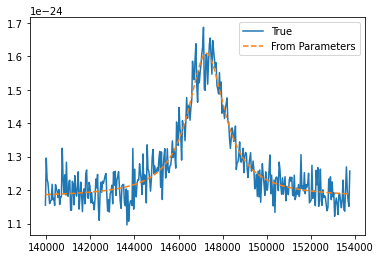

In [52]:
# Plot the values of a Lorentzian() over the spectrum itself
freq, spec = process_csv_file("/content/split_detection/cha_st80_1.CSV", "m^2/Hz")
args = [freq, 4.30918947e-25, 1.47263669e+05, 1.02057514e+03, 1.17817749e-24]
lorentzian_object = Lorentzian(*args)
plt.plot(freq, spec, linestyle="solid", label="True")
plt.plot(freq, lorentzian_object.values, linestyle="dashed", label="From Parameters")
plt.legend()
plt.show()

In [ ]:
# Check the values attributes
lorentzian_object.values

In [54]:
# Dict. of attributes:values
lorentzian_object.all_values()

{'fit_area': 4.593242202117233e-22,
 'linewidth': 2041.15028,
 'mechanical_frequency': 1.608986006520053e-24}

In [55]:
chb = SplitBandData("/content/split_detection/", "chb_st80_1.CSV", "m^2/Hz")
chb_lorentzian = chb.init_lorentzian()
chb_lorentzian.all_values()

{'fit_area': 6.88723753192296e-22,
 'linewidth': 20.0,
 'mechanical_frequency': 5.217704223048308e-24}

---

In [68]:
rnum = np.random.randint(1,125)
#rnum=68

mySplitBand = SplitBandData("/content/split_detection/", f"cha_st80_{rnum}.CSV", "m^2/Hz")
myHeterodyne = HeterodyneData("/content/heterodyne/", f"het_st80_{rnum}.CSV", "V^2/Hz")

In [69]:
leftL, mainL, rightL = myHeterodyne.init_3lorentzian()
leftL.all_values()

{'fit_area': 2.7639923848544526e-06,
 'linewidth': 10.0,
 'mechanical_frequency': 2.6204829651109377e-06}

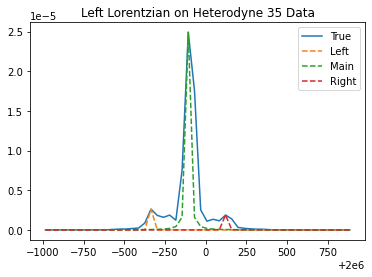

In [70]:
het_freq = center_zoom(myHeterodyne.frequencies, 50)
het_spec = center_zoom(myHeterodyne.spectrum, 50)
left_fit = center_zoom(leftL.values, 50)
main_fit = center_zoom(mainL.values, 50)
right_fit = center_zoom(rightL.values, 50)


plt.plot(het_freq, het_spec, linestyle="solid", label="True")
plt.plot(het_freq, left_fit, linestyle="dashed", label="Left")
plt.plot(het_freq, main_fit, linestyle="dashed", label="Main")
plt.plot(het_freq, right_fit, linestyle="dashed", label="Right")
plt.title(f"Left Lorentzian on Heterodyne {rnum} Data")
plt.legend()
plt.show()

## Main

In [48]:
# Main

# Define constants 
SPLITBAND_UNITS = "m^2/Hz"
CHANNEL_A_DIRECTORY = "/content/split_detection/"
CHANNEL_A_PATTERN = "cha_st80_*.CSV"
CHANNEL_B_DIRECTORY = "/content/split_detection/"
CHANNEL_B_PATTERN = "chb_st80_*.CSV"

HETERODYNE_UNITS = "V^2/Hz"
HETERODYNE_DIRECTORY = "/content/heterodyne/"
HETERODYNE_PATTERN = "het_st80_*.CSV"

# Lists of filenames for each of the data sets
_, cha_files = match_filenames_in_dir(CHANNEL_A_PATTERN, CHANNEL_A_DIRECTORY)
_, chb_files = match_filenames_in_dir(CHANNEL_B_PATTERN, CHANNEL_B_DIRECTORY)
_, het_files = match_filenames_in_dir(HETERODYNE_PATTERN, HETERODYNE_DIRECTORY)

cha_area_pct_err = accumulate_splitband_areas(cha_files)
plot_percent_error(cha_area_pct_err, title="Channel A: % Error btwn Raw Area and Fit Area")

chb_area_pct_err = accumulate_splitband_areas(chb_files)
plot_percent_error(chb_area_pct_err, title="Channel B: % Error btwn Raw Area and Fit Area")

AttributeError: ignored

# Comparing ADEVs (Jan 27)

In [ ]:
# Try fitting for all the files
for i in range(1, 125):
    split_a = SplitBandData("/content/split_detection/", f"cha_st80_{i}.CSV", "m^2/Hz")
    split_b = SplitBandData("/content/split_detection/", f"chb_st80_{i}.CSV", "m^2/Hz")
    het = HeterodyneData("/content/heterodyne/", f"het_st80_{i}.CSV", "V^2/Hz")

    try:
        split_a.fit_1d_lorentzian()
        split_b.fit_1d_lorentzian()
        het.fit_3d_lorentzian()
    except:
        print(f"FAILED = {i}")

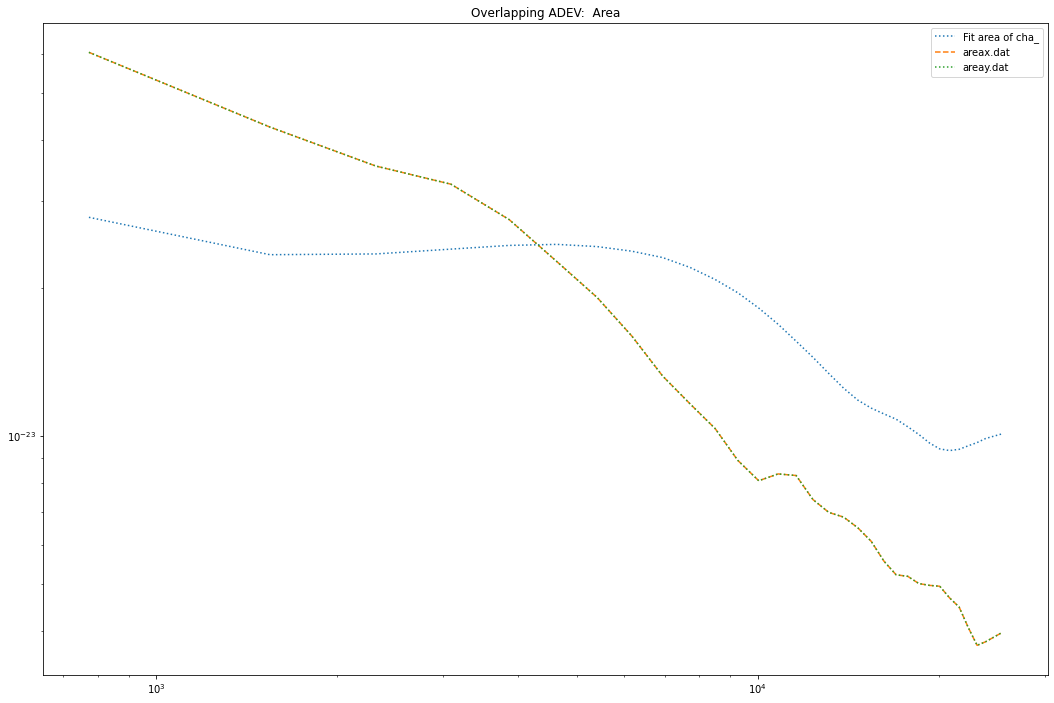

In [ ]:
raw_area_cha = []
fit_area_cha = []
for i in range(1, 125):
    split_a = SplitBandData("/content/split_detection/", f"cha_st80_{i}.CSV", "m^2/Hz")
    split_a.fit_1d_lorentzian()
    raw_area_cha.append(split_a.raw_area)
    fit_area_cha.append(split_a.fit_area)
extr_raw_taus, extr_raw_oadev = overlapping_allan_deviation(raw_area_cha, 1/772.26)
extr_fit_taus, extr_fit_oadev = overlapping_allan_deviation(fit_area_cha, 1/772.26)


areax = np.loadtxt("/content/split_detection/areax.dat")
areay = np.loadtxt("/content/split_detection/areax.dat")
areax_taus, areax_oadev = overlapping_allan_deviation(areax, 1/772.26)
areay_taus, areay_oadev = overlapping_allan_deviation(areay, 1/772.26)


plt.figure(figsize=(18,12))
#plt.loglog(extr_raw_taus, extr_raw_oadev, linestyle="solid", label="Fit area of cha_")
plt.loglog(extr_fit_taus, extr_fit_oadev, linestyle="dotted", label="Fit area of cha_")
plt.loglog(areax_taus, areax_oadev, linestyle="dashed", label="areax.dat")
plt.loglog(areay_taus, areay_oadev, linestyle="dotted", label="areay.dat")
plt.title("Overlapping ADEV:  Area")
plt.legend()
plt.show()

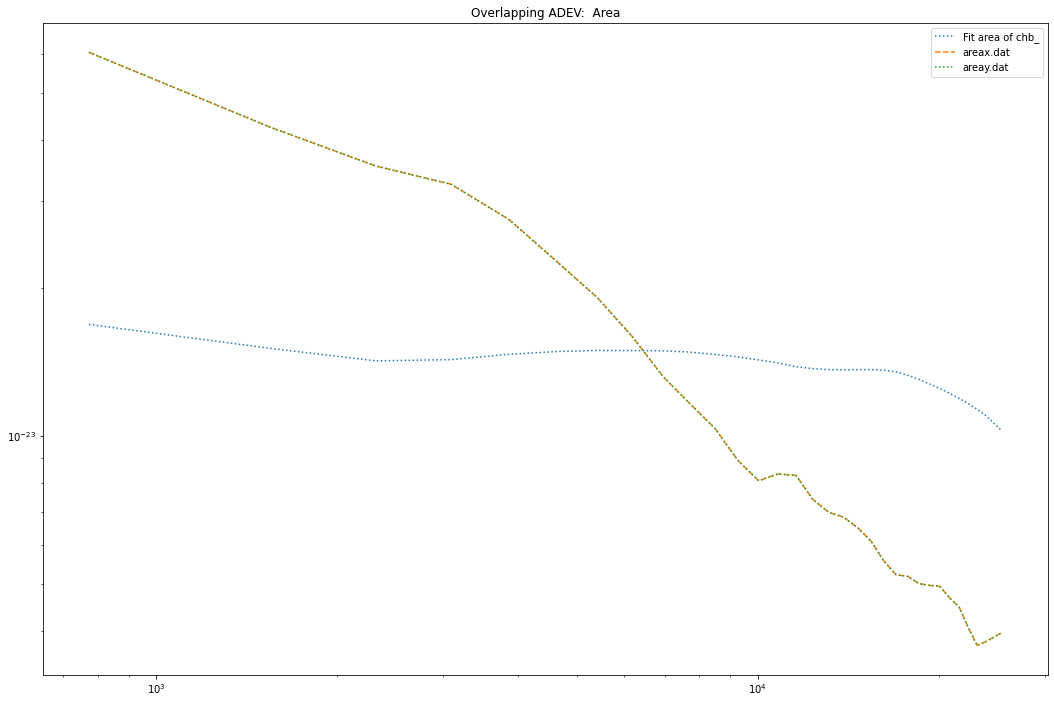

In [ ]:
raw_area_chb = []
fit_area_chb = []
for i in range(1, 125):
    split_b = SplitBandData("/content/split_detection/", f"chb_st80_{i}.CSV", "m^2/Hz")
    split_b.fit_1d_lorentzian()
    raw_area_chb.append(split_b.raw_area)
    fit_area_chb.append(split_b.fit_area)
extr_raw_taus, extr_raw_oadev = overlapping_allan_deviation(raw_area_chb, 1/772.26)
extr_fit_taus, extr_fit_oadev = overlapping_allan_deviation(fit_area_chb, 1/772.26)


areax = np.loadtxt("/content/split_detection/areax.dat")
areay = np.loadtxt("/content/split_detection/areax.dat")
areax_taus, areax_oadev = overlapping_allan_deviation(areax, 1/772.26)
areay_taus, areay_oadev = overlapping_allan_deviation(areay, 1/772.26)


plt.figure(figsize=(18,12))
#plt.loglog(extr_raw_taus, extr_raw_oadev, linestyle="solid", label="Fit area of chb_")
plt.loglog(extr_fit_taus, extr_fit_oadev, linestyle="dotted", label="Fit area of chb_")
plt.loglog(areax_taus, areax_oadev, linestyle="dashed", label="areax.dat")
plt.loglog(areay_taus, areay_oadev, linestyle="dotted", label="areay.dat")
plt.title("Overlapping ADEV:  Area")
plt.legend()
plt.show()

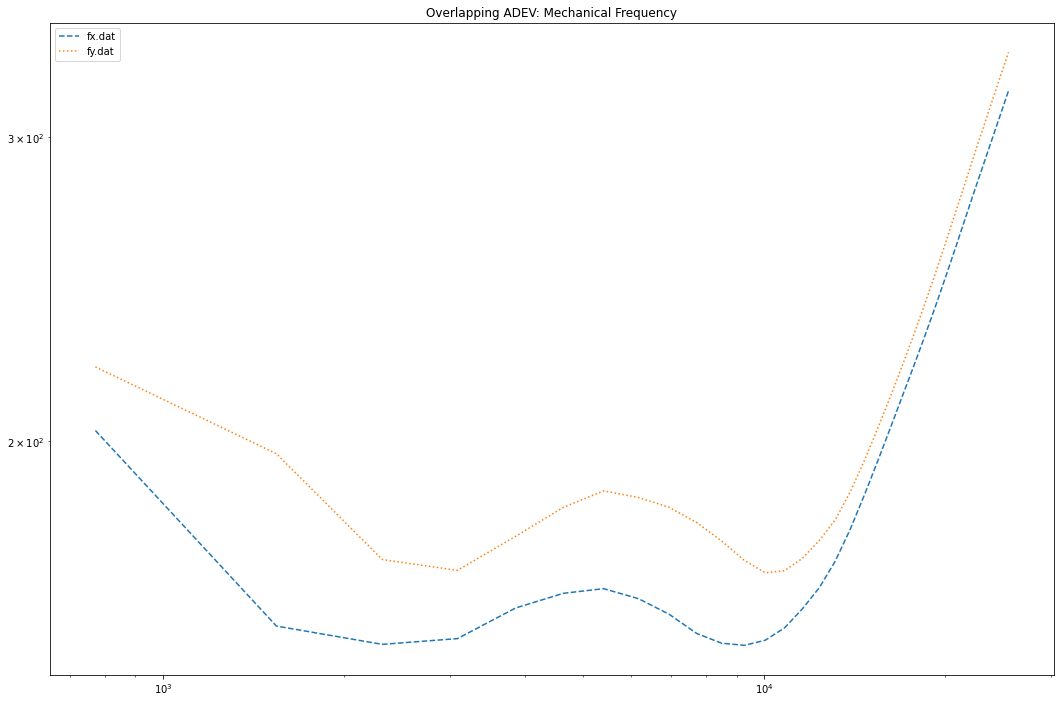

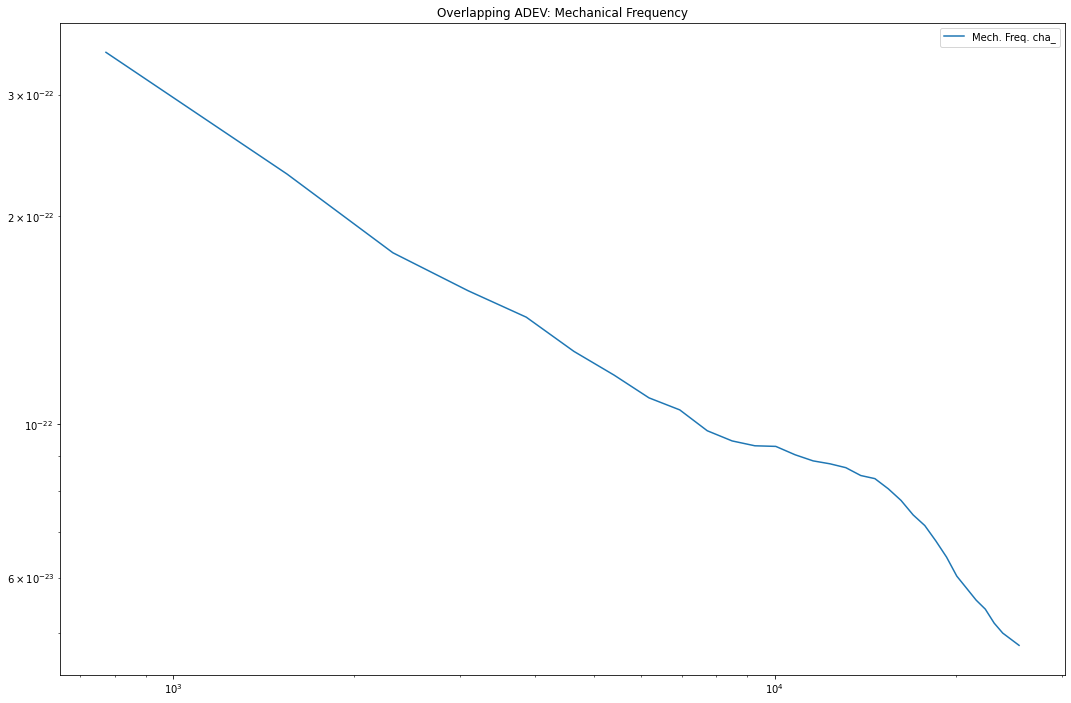

In [ ]:
mechanical_frequency = []
for i in range(1, 125):
    split_a = SplitBandData("/content/split_detection/", f"cha_st80_{i}.CSV", "m^2/Hz")
    split_a.fit_1d_lorentzian()
    mechanical_frequency.append(split_a.mechanical_frequency)
extr_taus, extr_oadev = overlapping_allan_deviation(mechanical_frequency, 1/772.26)

fx = np.loadtxt("/content/split_detection/fx.dat")
fy = np.loadtxt("/content/split_detection/fy.dat")
fx_taus, fx_oadev = overlapping_allan_deviation(fx, 1/772.26)
fy_taus, fy_oadev = overlapping_allan_deviation(fy, 1/772.26)


plt.figure(figsize=(18,12))
#plt.loglog(extr_taus, extr_oadev, linestyle="dashed", label="Raw area of cha_")
plt.loglog(fx_taus, fx_oadev, linestyle="dashed", label="fx.dat")
plt.loglog(fy_taus, fy_oadev, linestyle="dotted", label="fy.dat")
plt.title("Overlapping ADEV: Mechanical Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(18,12))
plt.loglog(extr_taus, extr_oadev, linestyle="solid", label="Mech. Freq. cha_")
#plt.loglog(taus, oadev, label="fx.dat")
plt.title("Overlapping ADEV: Mechanical Frequency")
plt.legend()
plt.show()

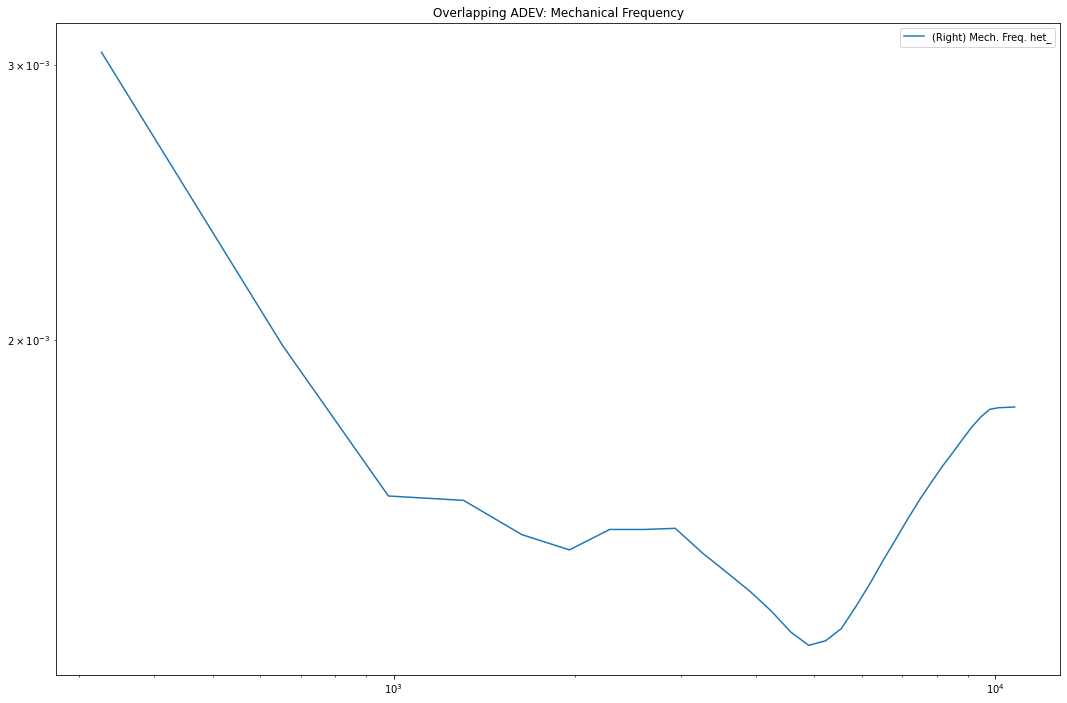

In [ ]:
left_mechanical_frequency = []
for i in range(1, 125):
    het = HeterodyneData("/content/heterodyne/", f"het_st80_{i}.CSV", "V^2/Hz")
    het.fit_3d_lorentzian()
    left_mechanical_frequency.append(het.right_mechanical_frequency)
extr_taus, extr_oadev = overlapping_allan_deviation(left_mechanical_frequency, 1/326.613)

neg_sideband = np.loadtxt("/content/heterodyne/fit_neg_sideband.dat")
post_sideband = np.loadtxt("/content/heterodyne/fit_pos_sideband.dat")
neg_taus, neg_oadev = overlapping_allan_deviation(neg_sideband[:,1], 1/326.613)
pos_taus, pos_oadev = overlapping_allan_deviation(pos_sideband[:,1], 1/326.613)


plt.figure(figsize=(18,12))
plt.loglog(extr_taus, extr_oadev, linestyle="solid", label="(Right) Mech. Freq. het_")
#plt.loglog(neg_taus, neg_oadev, linestyle="dashed", label="fit_neg_sideband.dat")
#plt.loglog(pos_taus, pos_oadev, linestyle="dotted", label="fit_pos_sideband.dat")
plt.title("Overlapping ADEV: Mechanical Frequency")
plt.legend()
plt.show()



In [ ]:
neg_sideband[:, 6]

array([3.97645796e-14, 3.79827959e-14, 3.79321928e-14, 3.93991660e-14,
       3.68307138e-14, 3.68742956e-14, 3.56824683e-14, 3.76850783e-14,
       3.90984087e-14, 3.82901478e-14, 3.81176526e-14, 3.73049190e-14,
       3.67735169e-14, 3.57686078e-14, 3.52385814e-14, 3.58065301e-14,
       3.66542930e-14, 3.57200700e-14, 3.70101791e-14, 3.73784737e-14,
       3.75351307e-14, 3.57190973e-14, 3.58153718e-14, 3.60815629e-14,
       3.82632211e-14, 3.70943632e-14, 3.87378269e-14, 3.81683569e-14,
       3.96340304e-14, 3.86886631e-14, 3.83388153e-14, 3.77945069e-14,
       4.11269392e-14, 3.76623496e-14, 3.97285503e-14, 4.05379748e-14,
       3.95030854e-14, 3.75972743e-14, 3.82121587e-14, 3.98762999e-14,
       3.92907484e-14, 3.99169318e-14, 3.87509149e-14, 4.17057600e-14,
       4.04629643e-14, 3.63809628e-14, 4.01806692e-14, 4.17471149e-14,
       4.01347475e-14, 3.86526269e-14, 4.08380298e-14, 4.21328337e-14,
       3.95102058e-14, 4.44140127e-14, 4.24131267e-14, 4.02380572e-14,
      